<a href="https://colab.research.google.com/github/Dyl-cmyk/datascience/blob/Notes/Unit4NotesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

#Unit 4: Hierachical Models

In this unit we will cover how to model data containing sepreate, but related, groups. We'll start with a continuous data example; here's how we'll break it down. We will:

1. Make a model and assume that the groups are unrelated, or *independent*
2. Alter that model by changing our assumption so that the groups are related, or have some amount of *dependence*
3. Compare and contrast those models using a plot.
4. Cover the same concept with a discrete data set, introducing some complexities and problems with creating groups

Let's get started.

## Loading and Visualizing our Data

The below chemical shift data set is different from that used previous unit; it contains theoreitcal and experimental chemical shift values for 19 different amino acids. Let's view the raw data to see what I mean.

In [2]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [3]:
#print a the begining and end of the raw data set, as a pandas dataframe
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


We are interested in only three columns for right now:
- aa, which stands for amino acid
- theo, which is the theoretical chemical shift value, calculated using "quantum methods", to quote our textbook.
- exp, which is the observed chemical shift value from Nuclear Magnetic Reasonance (NMR)

The following two plots help visualize the theoriteical values for each protein, and the experimental values for each protein.

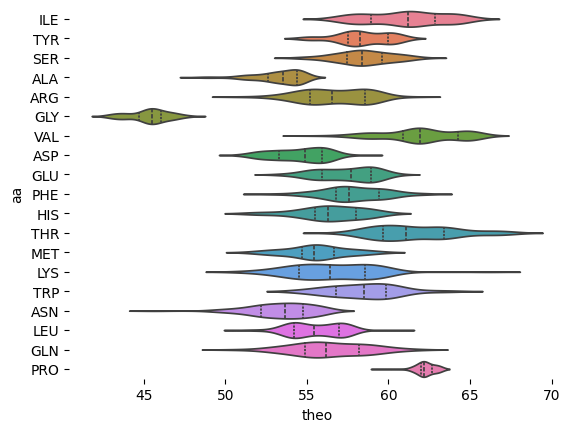

In [4]:
#visualize theoretical chem shift values for all the amino acids
sns.violinplot(cs_data, x='theo', y='aa', inner='quart',hue='aa')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

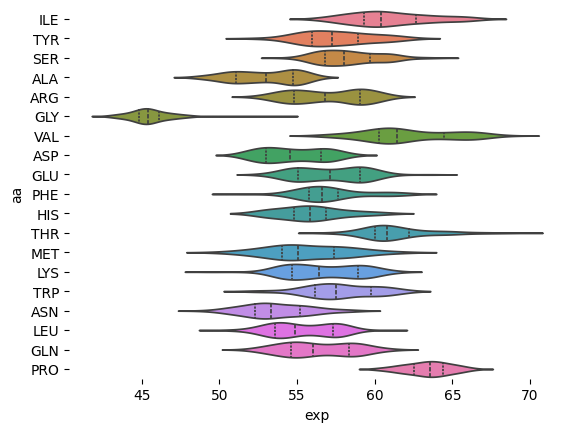

In [5]:
#visualize experimental chem shift values for all the amino acids
sns.violinplot(cs_data, x='exp', y='aa', inner='quart', hue='aa')
sns.despine(top=True, right=True, bottom=True, left=True)

**Task1**:

Without building a model, answer the following:

For each amino acid, are the theoretical chemical shift values different from
the experimental values?

**Answer1**:

Yes, they are very close in some scenairos, but they are all different...I think

###Raw Difference

Here's code to find the raw difference between the theoretical and expermental chemical shift values within each amino acid, and to store that difference in our data.

In [6]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [7]:
#print the dataframe with the new column
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


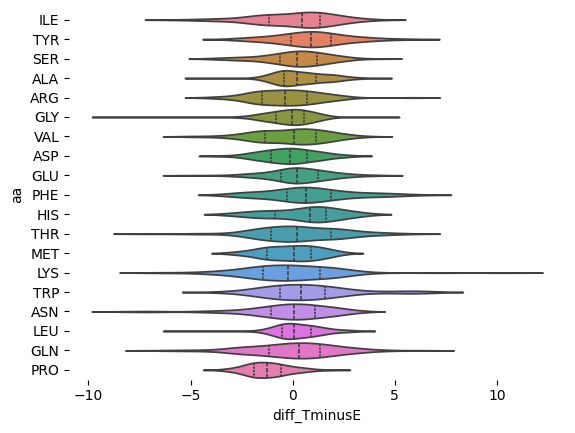

In [8]:
#visualize difference in chem shift values for all the amino acids
sns.violinplot(cs_data, x='diff_TminusE', y='aa', inner='quart',hue='aa')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

**Task2**:

Using the graph of raw differences, answer the following:

- For each amino acid, are the theoretical chemical shift values different from
the experimental values?

- If you had to use one likelihood to model the chemical shift for each amino acid, which one would you use?

**Answer2**:

- They seem to be centered around 0, which would mean no difference in the theoretical and experimental values.

Making a statement based only on raw differences should make you uncomfortable though. It'd be nicer if we could make some statement like: "there's a \_\_% chance the true difference between the theo and exp chem shift values of \_\_ amino acid is \_\_ units from 0."

- I'd use normal or StudentT likelihood. Only a few of the amino acids appear to have moderate skew, and the slightly more seem to have an outlier or two.

###Making it Personalized

Visualizing the raw data and making a guess from it is neccessary, but not sufficient. Was does that mean? We have, at this point, got to the start line.

We understand the information we have as well as we can, and we've used our knowldge to make a preliminary guess: we think the difference between the theoretical chemical shift values and the experimental chemical shift values is around zero. In other words, **we think the "quantum methods" more or less predict the actual chemical shift values in the 19 amino acids we looked at.**

Its the "more or less" part in the last statement that our model will boslter. In the simple models from these first 5 units, its often possible to visualize the raw data like we did and come to a reasonable conclusion. Our models, right now, confirm or deny our intuition, and also give us a mathematical way of saying how confident we should be in our conclusion.

In later units, with more complicated data and goals, our models will end up being the best summarization method. But we should always try to make visualizations without our models first, as we did here.


In order to make a model for the differences between the chemical shift values for each amino acid--and thus confirm our hypothesis--, we need a to give our model a way to know which difference corresponds to which amino acid. The next few code blocks do this.

In [9]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [10]:
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [11]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

For now, we'll also make the assumption that all our priors, and our likelihood, are normal/halfnormal. This is for two reasons:
- To keep things simple while we explore hierarchical models
- If all we know about our data is that there is an expected value and variation around that value, then its distribution will be normal. This a good assumption to start our model building process with.

##Continuous Data, Independent Groups

Our data is grouped into 19 different amino acids. To start, I'll assume that knowing something about one amino acid  provides 0 information about any of the other amino acids. This assumptions seems wrong to me, but we'll follow through with assuming amino acids are independent because

- We will contrast this independent model with a partial dependence model, to see how changing independence between amino acid assumption changes our analysis.

**Task3**:

Do you think amino acids are independent from one another, with respect to chemical shift and quantum methods?

**Answer3**:

Some more than others...I don't exactly know what "chemical shift" and "quantum methods" means though, so I may be wrong

Let's see the code for the model where we assume each amino acid is independent from one another.

In [12]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ', mu=0, sigma=10,
                  dims="aa")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="aa")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh = pm.sample()

Output()

Output()

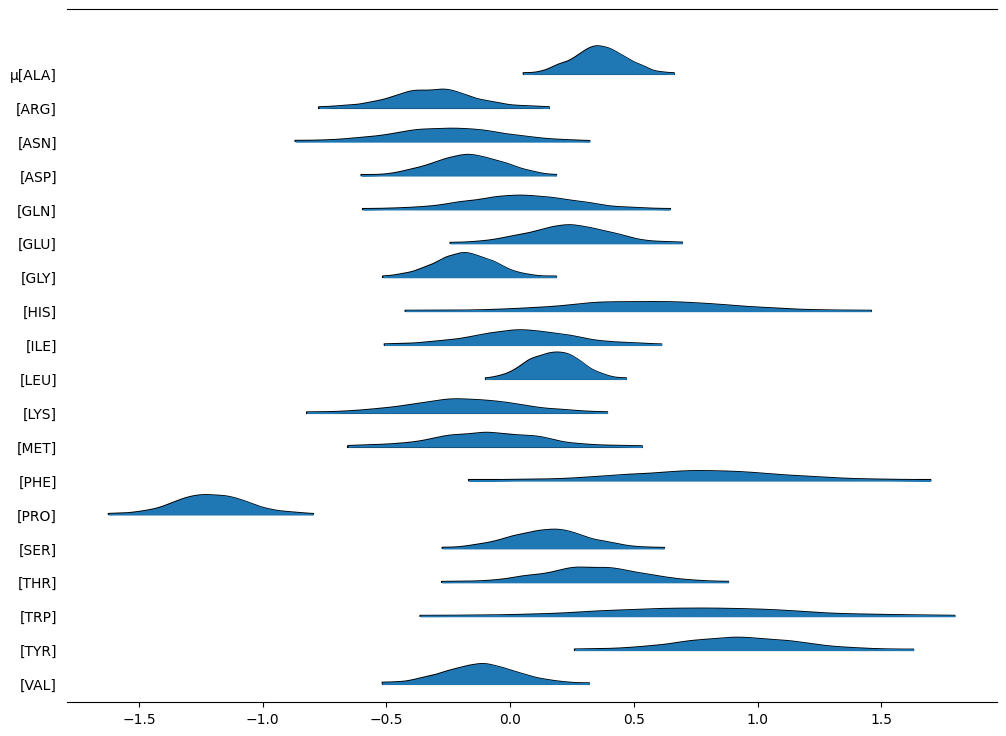

In [13]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
axes = az.plot_forest(idata_cs_nh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task4**:

Using cs_nh_model and the visualization of its posteriors above, answer the following:

Is there a difference between the theoretical and experimental chemical shift values in the amino acids from cs_data?

**Answer4**:

Yes there is. With many of the graphs centerd outside the 0.0 area showing this. Even if the diffence is small (inside 2 whatevers-percent?-) it exists

-

-

-

PRO, TYR, and ALA look like they are poorly predicted by the theoretical 'quantum methods'; there's less than a 99.7% chance of the difference between the theoretical chem shift value and eht experimental value being the same. PRO and TYR especially look most doubtful--I'd immediately recommend further reasearch into why the quantum methods fared so poorly.

There are other amino acids for which the efficacy of the quantum methods is questionable. These are: TRP, PHE, HIS, and possible even LEU. While all their psoterior distributions HDI's cover 0, the part of their posterior that covers 0 is a low probability density region. Remember, the HDI I chose is arbitrary; its the whole posterior that I should use to make my decision.

The remaining 12 animo acids I would classify as 'good enough'. I'd then record their posteriors' mean, call that the approximate error term when using the 'quantum methods', and move on.

I have more to say, but I'll finish my thoughts when we've finished our analysis  by removing our independence assumption.


## Continuous Data, some Dependence among Groups

The model we made and any conclusions we can reach from it are only as good as our assumptions, and we assumed that using one amino acid to predict another was foolish.

We will now relax that assumption, and build a model that automatically uses information about the mean chemical shift of one amino acid to predict the mean of another.

By what black magic is this possible? Before answering that question, and I'll ask you a different question.

**Task5**:

Can a prior have a prior? If so, what would that do, and why would we ever want that?

**Answer5**:

Yes, the Priors prior would help inform the posterior (capital P Prior). This may be desired because it allows for a greater form of "cutomization" or statisical depth than before possible

###Intro to Hyperpriors

Here' how to use hyperpriors to let our knowledge of one amino acid's mean chemical shift affect anothers.

In [14]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

**Task6**:

Considering only the code for cs_h_model and cs_nh_model, write down similarities and differences.

**Answer6**

There are two new lines of code:

```
μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
μ_sd = pm.HalfNormal('μ_sd', 10)
```

These are our hyperpriors.

These affect one more line;

```
μ = pm.Normal('μ', mu=0, sigma=10, dims="aa")
```

becomes

```
μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa")
```

Instead of the parameters for the $μ$ prior being 0 and 10, they become probability ditributions.

###The Result (Shrinkage)

Let's see what the hierarchical model cs_h_model's posterior looks like, and compare it to the non-hierarchical model, cs_nh_model.

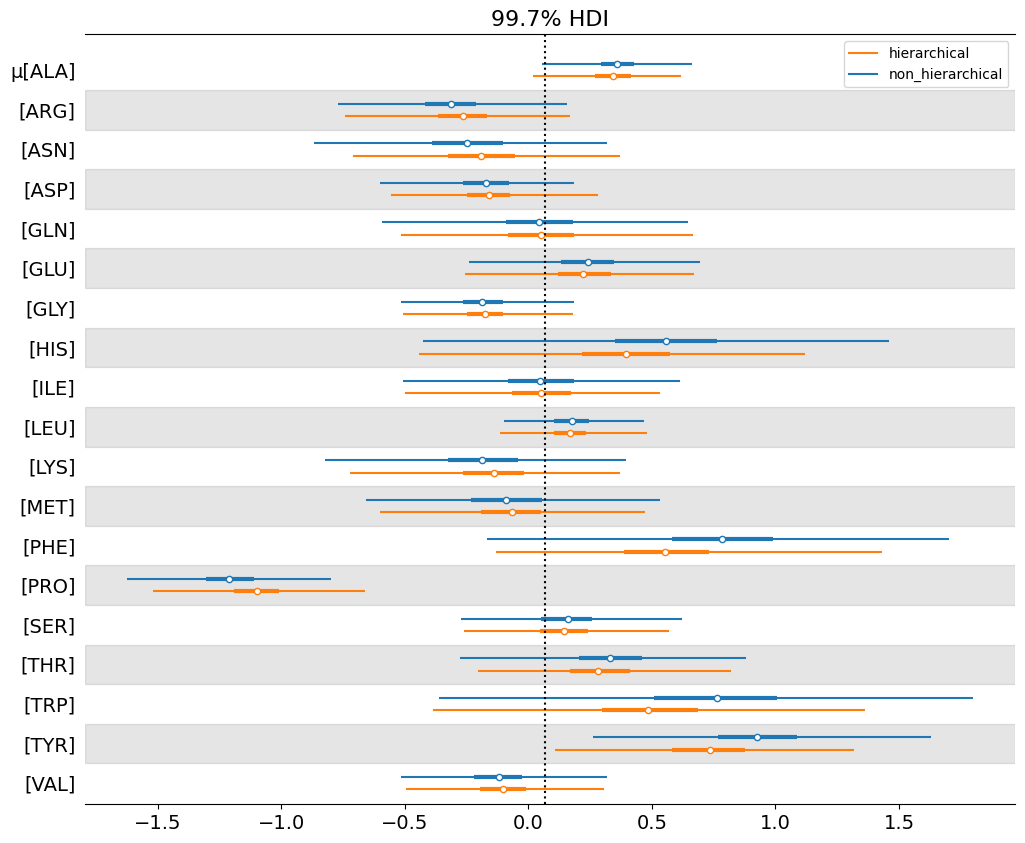

In [15]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_nh, idata_cs_h], kind="forestplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task7**:

Focus on the white dots, which are the means of the posteriors. How did allowing our model to use one amino acid's chemical shift mean to predict another's change our our predictions?

In other words, how do the hierarchical model, cs_h_model, and non-hierarchical model, cs_nh_model, differ?

**Answer7**:

The Hierarchial model is the model in the code we just ran (unitilzes hyper priors)
the non-Hierarchial model is the model from before we added the hyper priors. This variance is caused by shrinkage this is where all of the posteriors are drawn towards the mean of our hyperprior μ_mu. The mean of the of μ_mu is graphed as the vertical dotted black line; please don't confuse it with 0, which its close to.

This "shrinkage" has several properties:
- Shrinkage occurs more strongly the farther a group mean is from the overall mean. This is a property of means, of expected values.
- Groups with less data  experience more shrinkage. An inuitive way to rephrase that: its as if groups with less data are filled in with more "average" data points, thus pulling them towards the global mean
- It results in less variance. Look at teh graph; all the hierarchical lines are shorter than the non-hierarchical ones, even if its only by a little bit. This is actually a consequence of having a hyperprior--the more priors and hyperpriors stacked together, the more variation in the posterior is reduced.

For most of our amino acids, the shrinkage effect doesn't change our analysis. For example, PRO and TYR are still poorly predicted by quantum methods, despite their differences between theo and exp moving closer to 0. The 12 amino acids for  which we decided quantum methods were 'good enough' also look better predicted by theo, but this doesn't change our decision from earlier.


####Helpful visualizations

Below are two visualizations, one of the non-hierarchical model, and one of the hierarchical model. Make sure to use:
```
pm.model_to_graphviz()
```
whenever you have a model more complicated than cs_nh_model

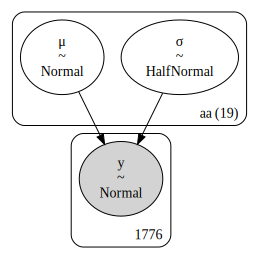

In [16]:
pm.model_to_graphviz(cs_nh_model)

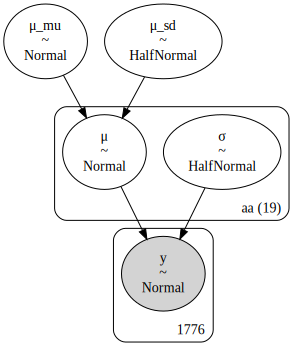

In [17]:
#the hyper priors only affect μ, and they are not split up by aa, by amino acid.
pm.model_to_graphviz(cs_h_model)

Notice that there's no hyperpriors for $σ$; this means we assume that the variance of one amino acid is independent from variance of another.

## Discrete Data, Dependent Groups

For our discrete data set, we'll do another sports statistics example, but this time we'll cover soccer (football).

We'll also use a model that doesn't behave well with pymc, but we'll still trust its predictions. We'll dicuss why.

The following code will load the data in, and do the neccessary cleaning. Make sure you're reading my comments--I didn't write them just to help me.

In [18]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

Look at the code below, focusing on the last two columns, goals and shots. This should remind you of the Wembanyama FT example, where we had makes and attempts.
Except there's 2681 players from the Premier League, Ligue 1, Bundesliga, Serie A, and La Liga, instead of 1 NBA player. There's also a categorical variable named position, and these data were complied from 2017-2020.

What's pertinent to use is that we'll use position the same way we used 'aa', amino acid, in the last example.

In [19]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


**Task8**:

Plot goals and shots from sccr_data. I'd use a violin plot.

Then consider how you would select a prior for goals and shots.

<Axes: ylabel='goals'>

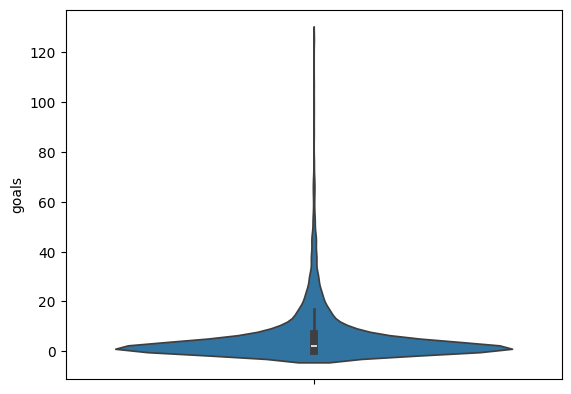

In [20]:
#ASNWER8
sns.violinplot(sccr_data.goals)

<Axes: ylabel='shots'>

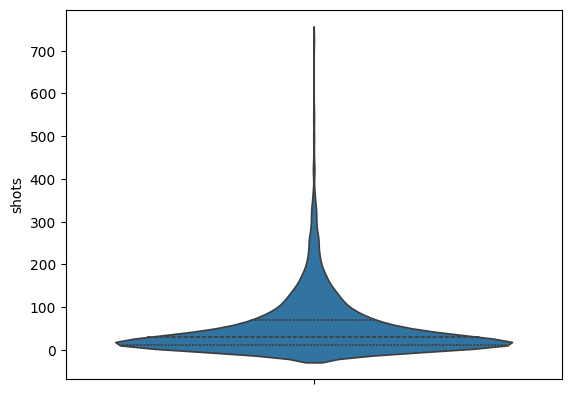

In [21]:
#ASNWER8 cont.
sns.violinplot(sccr_data.shots,inner='quart')

**Answer8 cont.**:


I made my priors look vaugely like these violin plots. I scaled the goals one down to a 0 to 1 scale though. I did this by tinkering with a beta dist for goals, adn a gamma dist for shots, using preliZ.

Why try to match the data with my prior? I'm confident that the data matches the true distribution--there's enough data anyway that the priors aren't going to do much anyway. They can really only hurt us, if I specify a nonsensical one by accident. Trying to match the data helps me avoid a nonsensical prior.

Previously, we would have turned goals into an array of $1$s, and [shots - goals] into an array of $0$s. That worked great when we only cared about one player, and its still possible now, but it'd be nice if we could just shove 'goals' and 'shots' into our model as is.

And we can! But there's a price to paid for that decision, this time around . . .

Before we discuss that price, let's review how to get pymc to recognize the grouping we care about, soccer position.

In [22]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [26]:
sccr_coords

{'pos': Index(['DF', 'FW', 'GK', 'MF'], dtype='object')}

**Task9**:

Explain what the code block above is doing, and why we need to do it before running our pymc model. Make sure to reference the chemical shift amnio acid example.

**Answer9**:

pos_codes is an array of the 4 strings that represent soccer position. We turn this into sccr_coords, so that pymc can more easily reference those 4 four soccer postions. It uses that information to make a prior for each position.

pos_idx is how our likelihood knows which player played which position, and therefore which prior to use for each player.

You'll probabliy want to print each thing out, like I did for the chemical shift amino acid example.

Run the model below; this model takes about 6-8 minutes to run, and would likely have many divergences if I hadn't changed the target_accept parameter. I changed target_accept from the default of 0.8 to 0.95, based off our textbooks recommendation. Generally, if you can get your model to 0 divergences just based off changing target_accept, then its good enough.

That said, you should probably have some idea why pymc is throwing a fit before you try to press on without changing your model structure. In this case, the main problem is that goal keepers rarely shoot goals, so their shooting percentage is hard to predict.

In [23]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Below is a visualization of the markov chains that did our inference for us and generated our posterior. A healthy chain is tightly packed, with a steady amplitude.

Notice that μ_p and  ν_p each had an unheathly chain, but that its other chains weren't so bad.
These are the chains for goals and shots for the Goal Keeper (GK) postion; as we'll see below, the model had a hard time predicting GK. That hard time ended up making the chains for μ and ν a little wobbly, and made our prediction for θ more uncertain as well.

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

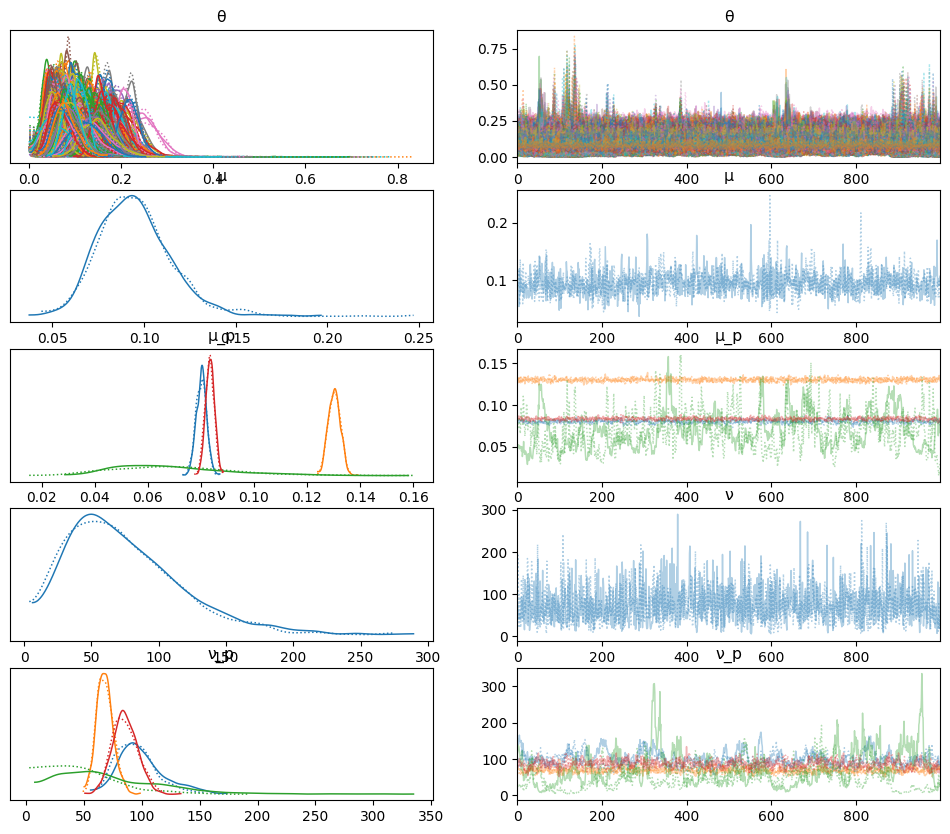

In [24]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr)

The following code will give you something called $\hat{R}$ values (pronounced "r hat"); these are how I know the faulty chains are from the GK position.

All you need to know about $\hat{R}$ values is that values between 1 and 1.001 are good, and values above 1.1 are bad.


In [44]:
#Using arviZ to find the rhat values
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 0.9995 0.9998 0.9999 ... 1.003 1.0 1.002
    μ        float64 8B 1.002
    μ_p      (pos) float64 32B 1.006 0.9998 1.01 1.007
    ν        float64 8B 1.002
    ν_p      (pos) float64 32B 1.02 1.001 1.09 1.002

**Task10**:

Using the values from running rhat function on idata_sccr, explain how I was able to know that the GK group is the problem.

**Answer10**:

I have a bad $\hat{R}$ value for μ_p for the 'GK', the goalkeeper position--the value is 1.242.  The GKs' ν_p value of 1.093 for $\hat{R}$ suboptimal as well. This would quite bad, if I didn't know that Goal Keepers mostly never shoot goals. GKs that do shot at the goal normally do in unusual circumstances, so most GKs have 0 goals and shots, but a few don't. Defenders (DF) also present this issue, but to a much smaller extent.

The $\hat{R}$ values of course don't know all this; they're just pymc's way to tell me that these labels I arbitrarily assigned to the data are giving it trouble.

One more thing: your $\hat{R}$ values will be different from mine when you run the model--this is because pymc is using sampling to avoid actually calculating proabilities. So the actual $\hat{R}$ values change from run to run, but what doesn't change is that the GK data is hard to predict.

The following will plot the means for each position; you can see that the model has no idea what the shooting percentage (goals/shots) should be for GKs.

Its pretty confident about the other positions though, and its predictions seem to match reality. Forwards (FW) role on a scoccer team is to shoot goals, so it makes sense that they have a higher shooting precentage.

array([<Axes: >], dtype=object)

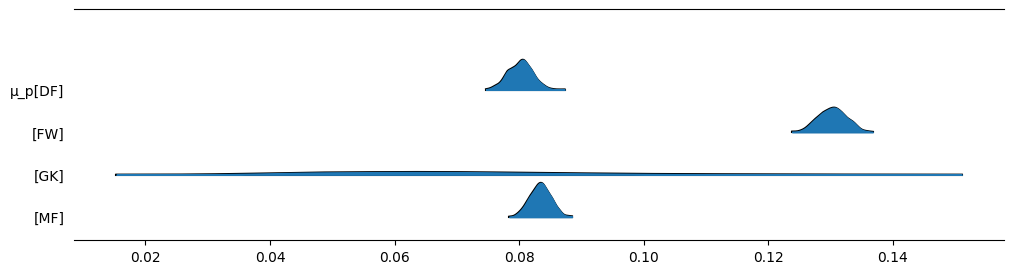

In [45]:
# plots a 99.8% HDI for the positions shooting percentage means
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

As a final treat, here's a visualization of how Lionel Messi's shooting percentage compares to other FWs, and to other professional soccer players.

Text(0.5, 1.0, 'Messi mean')

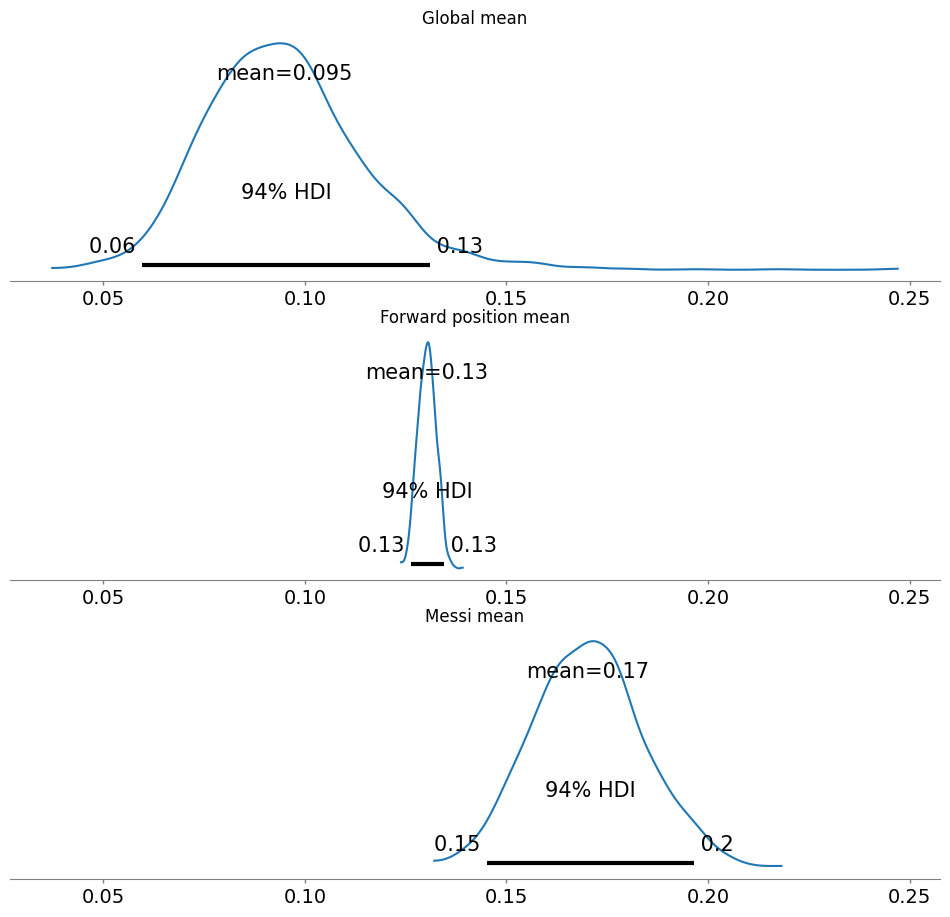

In [46]:
#preps a plot object to have three seperate plots, all with the same x axis
_, ax = plt.subplots(3, 1, figsize=(12, 11), sharex=True)

#plot the overall mean shooting percentage
az.plot_posterior(idata_sccr, var_names='μ', ax=ax[0])
ax[0].set_title(r"Global mean")

#plot the fowrads shooting percentage
az.plot_posterior(idata_sccr.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")

#plot Linonel Messi's shooting pecentage
az.plot_posterior(idata_sccr.posterior.sel(θ_dim_0=1457), var_names='θ', ax=ax[2])
ax[2].set_title(r"Messi mean")

## Summary

This unit covered hierarchical models, and not only showed us that priors can have priors, but that these hyper priors can be useful too.

Hyperpriors were used to allow sub groups within a data set to inform one another; we saw this with amino acids' chemical shift values pulling each other towards a common mean. This made us more likely to conclude that a given amino acid was well predicted by theoretical methods.

We then finished by creating a model for professional soccer player shooting percentage. This model introduced us to some new model checking tools, and helped us learn that breaking our data into subgroups can make pymc's job harder, even if these group labels reflect reality.

All the models in this unit were more complicated than we've seen before, and they demanded that we study the structure of our raw data.To do this, we used soem new graphical tools.

In this unit's project, you'll work on example similar to the soccer data set, so that you can get more familiar with breaking a data set into groups, and then assigning priors to those groups. With that, you'll have the foundation for how to encode most context and assumptions into a model.

